In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.options.display.max_columns = None

import sys
import numpy as np
np.set_printoptions(threshold = sys.maxsize)
import matplotlib.pyplot as plt

# import xgboost as xgb
# print(xgb.__version__)

from joblib import load

from sklearn.metrics import PrecisionRecallDisplay, \
    precision_recall_curve, accuracy_score, \
    roc_curve, roc_auc_score, auc, f1_score, \
    confusion_matrix

In [2]:
mon_laun_test_path = "datasets/merged_dataset_test_done.csv"
# mon_laun_test_df = pd.read_csv(mon_laun_test_path, index_col = False, nrows = 90000)
mon_laun_test_df = pd.read_csv(mon_laun_test_path, index_col = False)

# display(mon_laun_test_df)

In [3]:
mon_laun_test_df_target = mon_laun_test_df[["Is Laundering"]].astype(int)
mon_laun_test_df_data = mon_laun_test_df.drop(columns = ["Is Laundering"])

display(mon_laun_test_df_target.shape)
display(mon_laun_test_df_data.shape)

drop_columns = ['Timestamp', \
                'sourceAccountID', 'sourceAccount', 'From Bank', 'Account', \
                'targetAccountID', 'targetAccount', 'To Bank', 'Account.1', \
                'Receiving Currency', 'Payment Currency', 'Payment Format'    
               ]

# remaing columns ['transactionID', 'Timestamp_float', \
#                 'Amount Received', 'Receiving CurrencyID', \
#                 'Amount Paid', 'Payment CurrencyID', \
#                 'Payment FormatID'
#                 ]
# NOTE: graph and vertex feature are included

mon_laun_test_df_data = mon_laun_test_df_data.drop(columns = drop_columns)

(1015669, 1)

(1015669, 265)

In [4]:
display(mon_laun_test_df_target.dtypes)
display(mon_laun_test_df_data.dtypes)
# display(mon_laun_test_df_data)

X_test = mon_laun_test_df_data.to_numpy()
y_test = mon_laun_test_df_target.to_numpy()

Is Laundering    int64
dtype: object

transactionID             float64
Timestamp_float           float64
Amount Received           float64
Receiving CurrencyID      float64
Amount Paid               float64
                           ...   
dest_max_col11_in         float64
dest_median_col11_in      float64
dest_var_col11_in         float64
dest_skew_col11_in        float64
dest_kurtosis_col11_in    float64
Length: 253, dtype: object

In [5]:
xgb_model = load("xgb_best_model_params.joblib") # NOTE: loading xgb with the best params for testing
display(xgb_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
# use the default threshold of 0.5
y_pred_class = xgb_model.predict(X_test)

y_pred = xgb_model.predict_proba(X_test)[:, 1]

# print(y_pred_class[:10])
# print(y_pred[:10])
# print(y_test[:10]) # list of lists

In [7]:
mean_accuracy = xgb_model.score(X_test, y_test)
print("Mean Accuracy: %.2f%%" % (mean_accuracy * 100.0))

Mean Accuracy: 99.84%


In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion matrix
    # positive = 1
    # negative = 0
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
print([tn, fp, fn, tp])

# FalsePositiveRate = FalsePositives / (FalsePositives + TrueNegatives) --> to 0
# TruePositiveRate = TruePositives / (TruePositives + False Negatives) --> to 1 --> sensitivity/recall
# Precision = TruePositives / (TruePositives + FalsePositives) --> to 1


# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    # imbalanced binary classification
    # bias the predictive behavior of a classification model
f1_score_value = f1_score(y_test, 
                          y_pred_class
                          # labels, 
                          # pos_label, 
                          # average, 
                          # sample_weight, 
                          # zero_division
                         )
print("F1 score: %.2f%%" % (f1_score_value * 100.0))
# NOTE: find std(+-) of f1-scores based on different hyper-parameters (as many as the seeds used in CV)

[1013202, 670, 956, 841]
F1 score: 50.85%


AUC: 46.35%


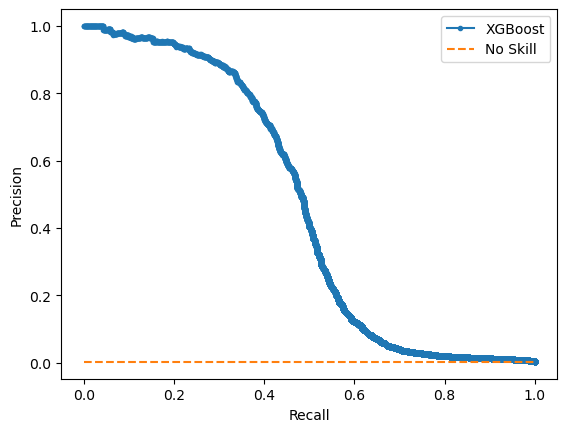

In [9]:
# Precision-Recall curves, AUC score
    # Recall (x) vs. Precision (y) --> (1,1) --> top-right corner
# NOTE: focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class)
precision, recall, pr_thresholds = precision_recall_curve(y_test, 
                                                  y_pred, 
                                                  # pos_label, 
                                                  # sample_weight
                                                 )
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# print(pr_thresholds)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
auc_score = auc(recall, precision)
print("AUC: %.2f%%" % (auc_score * 100.0))

plt.plot(recall, precision, marker = '.', label = 'XGBoost')

no_skill = sum(y_test) / len(y_test)
# no_skill = sum(y) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

ROC AUC: 73.37%


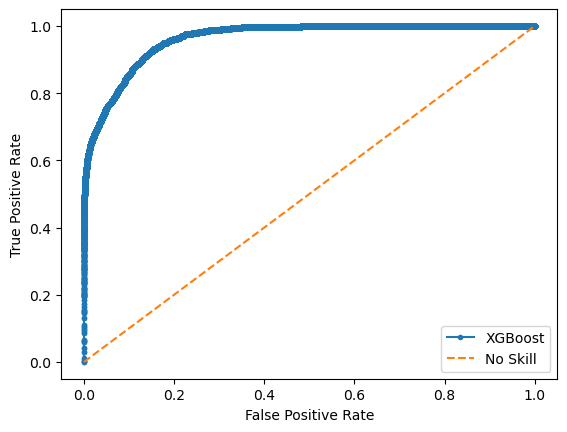

In [10]:
# ROC Curves, AUC score
    # False Positive Rate (x) vs. True Positive Rate (y) --> (0,1) --> top-left corner
# NOTE: small number of correct or incorrect predictions can result in a large change
fpr, tpr, roc_thresholds = roc_curve(y_test, 
                                 y_pred, 
                                 # pos_label, 
                                 # sample_weight
                                )
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# print(roc_thresholds)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
roc_auc = roc_auc_score(y_test, y_pred_class)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

plt.plot(fpr, tpr, marker = '.', label = 'XGBoost')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()